In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from joblib import dump

# Define the data types for each column (replace this with your actual dtypes dictionary)
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }
# Define the true numerical columns
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

# Load the data with specific data types
train = pd.read_csv('train.csv', dtype=dtypes)
train = train.sample(frac=0.20, random_state=42)

# Drop the columns as specified earlier
cols_to_drop = [
    'MachineIdentifier', 'AvSigVersion', 'IsBeta', 'RtpStateBitfield',
    'DefaultBrowsersIdentifier', 'AVProductsInstalled', 'HasTpm',
    'LocaleEnglishNameIdentifier', 'PuaMode', 'SMode', 'SmartScreen',
    'UacLuaenable', 'Census_DeviceFamily', 'Census_ProcessorClass',
    'Census_InternalBatteryType', 'Census_IsPortableOperatingSystem',
    'Census_IsFlightingInternal', 'Census_ThresholdOptIn',
    'OrganizationIdentifier', 'Census_IsWIMBootEnabled'
]
train.drop(columns=cols_to_drop, inplace=True)

# Separate the features and target variable
X = train.drop('HasDetections', axis=1)
y = train['HasDetections']

# Define numerical and categorical columns after dropping the unwanted columns
numerical_columns = [col for col in true_numerical_columns if col in X.columns]
categorical_columns = [col for col in X.columns if col not in numerical_columns]

# Preprocessing for numerical data: imputing missing values with median
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data: imputing missing values with the most frequent value then applying OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [2]:
# Define the model with added parameters to suppress warnings
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Split the data
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print("Classification report for training data:")
print(classification_report(y_train, y_train_pred))

print("Classification report for validation data:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix for training data:")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix for validation data:")
print(confusion_matrix(y_val, y_val_pred))

Classification report for training data:
              precision    recall  f1-score   support

           0       0.65      0.60      0.63    535420
           1       0.63      0.67      0.65    535157

    accuracy                           0.64   1070577
   macro avg       0.64      0.64      0.64   1070577
weighted avg       0.64      0.64      0.64   1070577

Classification report for validation data:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62    178629
           1       0.62      0.66      0.64    178231

    accuracy                           0.63    356860
   macro avg       0.63      0.63      0.63    356860
weighted avg       0.63      0.63      0.63    356860

Confusion Matrix for training data:
[[323891 211529]
 [175852 359305]]
Confusion Matrix for validation data:
[[106426  72203]
 [ 60129 118102]]


In [3]:
# Hyperparameter tuning with RandomizedSearchCV
parameters = {
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.6),
    'model__n_estimators': randint(100, 1000),
}

random_search = RandomizedSearchCV(clf, param_distributions=parameters, n_iter=10, scoring='roc_auc', cv=5, 
                                   n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Save the best model
best_model = random_search.best_estimator_
dump(best_model, 'best_model.joblib')

# Evaluating the best model
y_train_best_pred = best_model.predict(X_train)
y_val_best_pred = best_model.predict(X_val)

print("Classification report for training data with the best model:")
print(classification_report(y_train, y_train_best_pred))

print("Classification report for validation data with the best model:")
print(classification_report(y_val, y_val_best_pred))

print("Confusion Matrix for training data with the best model:")
print(confusion_matrix(y_train, y_train_best_pred))

print("Confusion Matrix for validation data with the best model:")
print(confusion_matrix(y_val, y_val_best_pred))

Classification report for training data with the best model:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65    535420
           1       0.65      0.69      0.67    535157

    accuracy                           0.66   1070577
   macro avg       0.66      0.66      0.66   1070577
weighted avg       0.66      0.66      0.66   1070577

Classification report for validation data with the best model:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62    178629
           1       0.63      0.67      0.65    178231

    accuracy                           0.64    356860
   macro avg       0.64      0.64      0.64    356860
weighted avg       0.64      0.64      0.64    356860

Confusion Matrix for training data with the best model:
[[335506 199914]
 [164995 370162]]
Confusion Matrix for validation data with the best model:
[[107940  70689]
 [ 59242 118989]]


In [8]:
print(random_search.best_params_)

{'model__learning_rate': 0.2347240713084175, 'model__max_depth': 7, 'model__n_estimators': 370}


In [4]:
import numpy as np

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)

# Evaluate the model's performance on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print("Test Accuracy:", test_accuracy)

# Optional: Detailed classification report and confusion matrix for test data
print("Classification report for test data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for test data:")
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.6368015468250855
Classification report for test data:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63    179012
           1       0.63      0.67      0.65    177848

    accuracy                           0.64    356860
   macro avg       0.64      0.64      0.64    356860
weighted avg       0.64      0.64      0.64    356860

Confusion Matrix for test data:
[[108677  70335]
 [ 59276 118572]]


Census_IsVirtualDevice_0.0: 0.014620620757341385
AVProductStatesIdentifier_53447.0: 0.010690007358789444
AVProductStatesIdentifier_63682.0: 0.00941397063434124
Platform_windows7: 0.009104500524699688
ProductName_win8defender: 0.008944679982960224
AVProductStatesIdentifier_43856.0: 0.005159500986337662
AVProductStatesIdentifier_43927.0: 0.0049601453356444836
OsVer_10.0.0.0: 0.0044375997968018055
Census_FirmwareManufacturerIdentifier_152.0: 0.004132535308599472
AVProductStatesIdentifier_46413.0: 0.0038269313517957926
AVProductStatesIdentifier_44141.0: 0.003764175111427903
AVProductStatesIdentifier_43807.0: 0.003493108320981264
IeVerIdentifier_81.0: 0.0034797738771885633
Census_OEMNameIdentifier_666.0: 0.00345293409191072
EngineVersion_1.1.14901.4: 0.0033428927417844534
Census_OSSkuName_CORE_SINGLELANGUAGE: 0.0033259293995797634
Census_OSInstallLanguageIdentifier_33.0: 0.0032077180221676826
GeoNameIdentifier_192.0: 0.002913816599175334
AppVersion_4.14.17639.18041: 0.0028843588661402464
AV

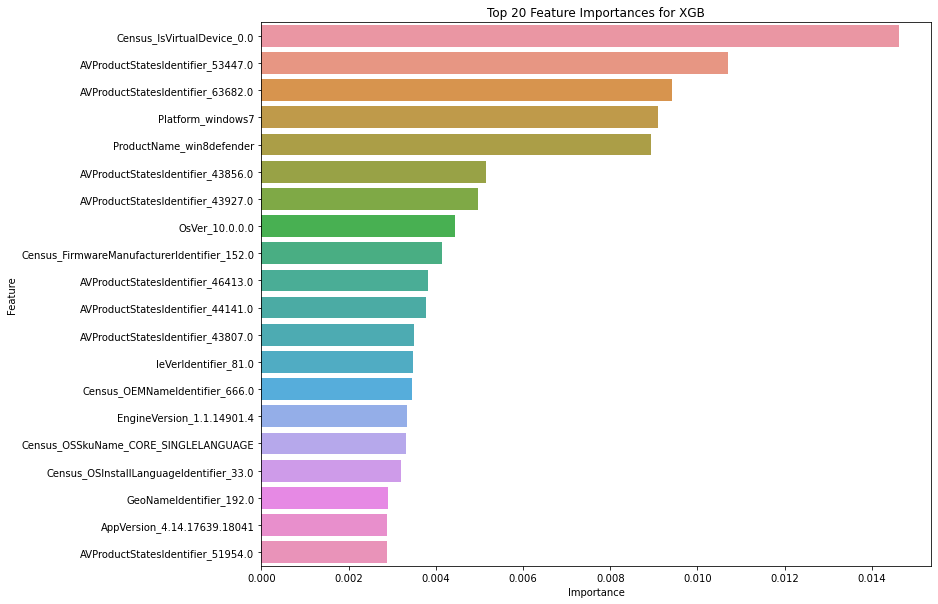

In [14]:
# Extracting feature names after OneHotEncoder
# Extracting feature names after OneHotEncoder
feature_names = numerical_columns + \
    list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns))

# Getting feature importances from the model
importances = best_model.named_steps['model'].feature_importances_

# Mapping these importances to the respective feature names
feature_importances = dict(zip(feature_names, importances))

# Sorting the features by importance
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted feature importances
for feature, importance in sorted_feature_importances[:20]:
    print(f"{feature}: {importance}")
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming importances and feature_names are already defined as in the previous explanation

# Convert the feature importances to a pandas DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances for XGB')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()